In [39]:
CONFIG_FILE = "model/model_v_0_5_config.py"

In [40]:
import importlib
import numpy as np
import json
import os
from typing import Any
from src.helpers import load_metadata, load_preprocessed_data, merge_set, standardize
import matplotlib.pyplot as plt

config = importlib.import_module(CONFIG_FILE.replace("/", ".").replace(".py", ""))
importlib.reload(config)


<module 'model.model_v_0_5_config' from '/Users/michaelbonon/Coding/stock-price-predictor/apps/stock-price-model/model/model_v_0_5_config.py'>

In [41]:
# Check if config file has all the required attributes
print(dir(config))

required_attributes = [
    "LEARNING_RATE",
    "MAX_EPOCHS",
    "PATIENCE",
    "VERSION_MAJOR",
    "VERSION_MINOR",
    "DATA_DIR",
    "DATA_FILENAME_MAP",
    "TRAINING_SET",
    "TEST_SET",
    "VALIDATION_SET",
    "MODELS_DIR",
    "LOAD_BASELINE_MODEL",
    "GET_INDEX_X_Y",
    "TRAINING_SET_PREPROCESSING",
    "LOSS_FUNCTION",
    "METRICS",
]

for attr in required_attributes:
    if not hasattr(config, attr):
        raise ValueError(f"Missing attribute {attr} in config file.")
    
if config.LOAD_BASELINE_MODEL and not hasattr(config, "BASELINE_MODEL_FILENAME"):
    raise ValueError("Missing attribute BASELINE_MODEL_FILENAME in config file.")

LEARNING_RATE = config.LEARNING_RATE
MAX_EPOCHS = config.MAX_EPOCHS
PATIENCE = config.PATIENCE
VERSION_MAJOR = config.VERSION_MAJOR
VERSION_MINOR = config.VERSION_MINOR
DATA_DIR = config.DATA_DIR
DATA_FILENAME_MAP = config.DATA_FILENAME_MAP
TRAINING_SET = config.TRAINING_SET
TEST_SET = config.TEST_SET
VALIDATION_SET = config.VALIDATION_SET
MODELS_DIR = config.MODELS_DIR
LOAD_BASELINE_MODEL = config.LOAD_BASELINE_MODEL
BASELINE_MODEL_FILENAME = config.BASELINE_MODEL_FILENAME if LOAD_BASELINE_MODEL else ""
GET_INDEX_X_Y = config.GET_INDEX_X_Y
TRAINING_SET_PREPROCESSING = config.TRAINING_SET_PREPROCESSING
LOSS_FUNCTION = config.LOSS_FUNCTION
METRICS = config.METRICS


['BASELINE_MODEL_FILENAME', 'DATA_DIR', 'DATA_FILENAME_MAP', 'GET_INDEX_X_Y', 'LEARNING_RATE', 'LOAD_BASELINE_MODEL', 'LOSS_FUNCTION', 'MAX_EPOCHS', 'METRICS', 'MODELS_DIR', 'Metadata', 'PATIENCE', 'TEST_SET', 'TRAINING_SET', 'TRAINING_SET_PREPROCESSING', 'VALIDATION_SET', 'VERSION_MAJOR', 'VERSION_MINOR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'df_windowed_to_index_x_y', 'pd']


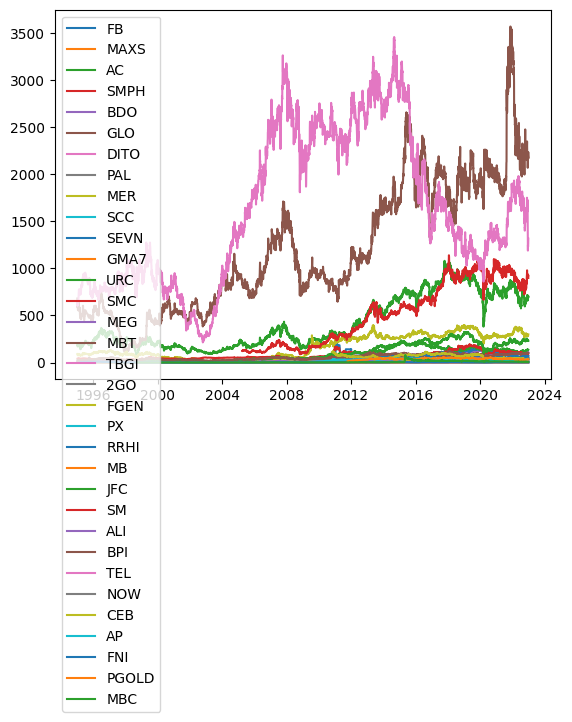

In [42]:
loaded_dataset = {}

COMBINED_SETS = TRAINING_SET + VALIDATION_SET + TEST_SET

for item in COMBINED_SETS:
    filename = DATA_FILENAME_MAP[item]["filename"]
    metadata_filename = DATA_FILENAME_MAP[item]["metadata"]

    metadata = load_metadata(DATA_DIR, metadata_filename)
    df = load_preprocessed_data(DATA_DIR, filename, metadata)
    
    index_data, feature_data, target_data = GET_INDEX_X_Y(df, metadata)

    loaded_dataset[item] = {
        "index": index_data,
        "x": feature_data,
        "y": target_data,
    }

    plt.plot(index_data, target_data)

plt.legend(COMBINED_SETS)



In [43]:
train_x = merge_set(TRAINING_SET, "x", loaded_dataset)
train_y = merge_set(TRAINING_SET, "y", loaded_dataset)
val_x = merge_set(VALIDATION_SET, "x", loaded_dataset)
val_y = merge_set(VALIDATION_SET, "y", loaded_dataset)
test_x = merge_set(TEST_SET, "x", loaded_dataset)
test_y = merge_set(TEST_SET, "y", loaded_dataset)

In [44]:

metadata_filename = DATA_FILENAME_MAP[TRAINING_SET[0]]["metadata"]
metadata = load_metadata(DATA_DIR, metadata_filename)

# Sample value of TRAINING_SET_PREPROCESSING
# TRAINING_SET_PREPROCESSING = [
#     ("Volume", ["z-score"]),
# ]

model_output = {}

for feature_name, preprocessing_steps in TRAINING_SET_PREPROCESSING:
    if feature_name not in metadata["features"]:
        raise ValueError(f"Feature {feature_name} not found in metadata.")
    
    target_index = metadata["features"].index(feature_name)
    for preprocessing_step in preprocessing_steps:
        if preprocessing_step == "z-score":
            training_mean = np.mean(train_x[:, :, target_index])
            training_std = np.std(train_x[:, :, target_index])
            standardize(train_x, target_index, training_mean, training_std)
            standardize(val_x, target_index, training_mean, training_std)
            model_output[f"{feature_name}_mean"] = str(training_mean)
            model_output[f"{feature_name}_std"] = str(training_std)
        else:
            raise ValueError(f"Preprocessing step {preprocessing_step} not supported.")

print("model_output", model_output)

model_output_params_filepath = "{}/v_{}_{}/{}".format(
  MODELS_DIR,
  VERSION_MAJOR,
  VERSION_MINOR,
  "model_output_params.json"
)
os.makedirs(os.path.dirname(model_output_params_filepath), exist_ok=True)
with open(model_output_params_filepath, "w") as f:
  json.dump(model_output, f)

model_output {'Volume_mean': '2601463.2', 'Volume_std': '8855982.0'}


In [45]:
from keras import layers, losses, metrics, callbacks, models, optimizers

feature_size = len(metadata["features"])
window_size = metadata["window_size"]

model = None

if LOAD_BASELINE_MODEL:
    model = models.load_model(f"{MODELS_DIR}/{BASELINE_MODEL_FILENAME}")
else:
    model = models.Sequential(
        [
            layers.Input(shape=(window_size, feature_size)),
            layers.LSTM(128),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(1),
        ]
    )

def compile_and_fit(
    model: models.Sequential,
    train_x: np.ndarray[str, Any],
    train_y: np.ndarray[str, Any],
    val_x: np.ndarray[str, Any],
    val_y: np.ndarray[str, Any],
    max_epochs: int,
    patience: int,
    learning_rate: float,
):
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min", restore_best_weights=True
    )

    model.compile(
        loss=LOSS_FUNCTION,
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        metrics=METRICS,
    )

    history = model.fit(
        train_x,
        train_y,
        epochs=max_epochs,
        validation_data=(val_x, val_y),
        callbacks=[early_stopping],
    )
    return history


compile_and_fit(model, train_x, train_y, val_x, val_y, MAX_EPOCHS, PATIENCE, LEARNING_RATE)


Epoch 1/50


2023-03-11 14:03:53.267133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-11 14:03:53.416191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   4/1822 [..............................] - ETA: 38s - loss: 79604.6094 - mean_absolute_error: 67.2525

2023-03-11 14:03:53.553790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1822/1822 [==============================] - ETA: 0s - loss: 15259.8555 - mean_absolute_error: 21.9295

2023-03-11 14:04:15.006340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-11 14:04:15.057652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1822/1822 [==============================] - 30s 16ms/step - loss: 15259.8555 - mean_absolute_error: 21.9295 - val_loss: 5.7737 - val_mean_absolute_error: 0.9751
Epoch 2/50
1822/1822 [==============================] - 27s 15ms/step - loss: 2089.9133 - mean_absolute_error: 9.0767 - val_loss: 3.4573 - val_mean_absolute_error: 0.7927
Epoch 3/50
1822/1822 [==============================] - 27s 15ms/step - loss: 1400.9774 - mean_absolute_error: 8.4827 - val_loss: 2.4469 - val_mean_absolute_error: 0.6278
Epoch 4/50
1822/1822 [==============================] - 27s 15ms/step - loss: 886.2618 - mean_absolute_error: 7.8272 - val_loss: 3.4616 - val_mean_absolute_error: 0.7406
Epoch 5/50
1822/1822 [==============================] - 27s 15ms/step - loss: 754.2423 - mean_absolute_error: 7.5386 - val_loss: 2.6399 - val_mean_absolute_error: 0.6683
Epoch 6/50
1822/1822 [==============================] - 27s 15ms/step - loss: 738.6957 - mean_absolute_error: 7.6448 - val_loss: 2.1007 - val_mean_absolute_

   1/1589 [..............................] - ETA: 9:30

2023-03-11 14:27:11.493446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-11 14:27:11.564373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1589/1589 [==============================] - 6s 4ms/step


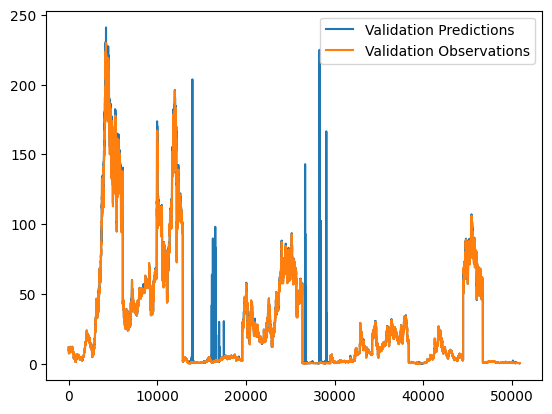

In [46]:
val_predictions = None

if model is not None:
    val_predictions = model.predict(val_x)
    plt.plot(val_predictions)
    plt.plot(val_y)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.show()
else:
    print("No model to evaluate")

In [47]:
model.summary()

print("Model version: {}.{}".format(VERSION_MAJOR, VERSION_MINOR))
print("Learning rate: ", LEARNING_RATE)
print("Max epochs: ", MAX_EPOCHS)
print("Patience: ", PATIENCE)
print("Training set: ", TRAINING_SET)
print("Validation set: ", VALIDATION_SET)
print("Load baseline model: ", LOAD_BASELINE_MODEL)

results = model.evaluate(val_x, val_y, verbose=0)
# Round the results to 3 decimal places.
results = [round(result, 3) for result in results]
print("Performance on validation set")
print(model.metrics_names)
print(results)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               68608     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 78,977
Trainable params: 78,977
Non-trainable params: 0
_________________________________________________________________
Model version: 0.5
Learning rate:  0.0001
Max epochs:  50
Patience:  50
Training set:  ['FB', 'MAXS', 'AC', 'SMPH', 'BDO', 'GLO', 'DITO', 'PAL', 'MER', 'SCC', 'SEVN', 'GMA7']
Validat

In [48]:
# Save the trained model into a file so we can use it to make predictions later
model_filepath = "{}/v_{}_{}/{}".format(
  MODELS_DIR,
  VERSION_MAJOR,
  VERSION_MINOR,
  "model.h5"
)
os.makedirs(os.path.dirname(model_filepath), exist_ok=True)
model.save(
  model_filepath,
  save_format="h5",
)
